# <font color="#03045e">Segmenting TravelTide Customers with K Means Algorithm:</font>

## <font color=#023e8a> Introduction:</font>

This Jupyter notebook is dedicated to **Customer Segmentation using the K-Means clustering** technique for **TravelTide**, a *fictional* e-booking startup. The notebook commences with data cleaning and preprocessing, leading to the core analysis of segmenting customers using K-Means. Subsequently, exploratory data analysis (EDA) is performed to gain insights into the generated customer segments.

The following data is the outcome of a SQL query that joined four tables:
* __Table 1. Users:__ user demographic information
* __Table 2. Sessions:__ information about individual browsing sessions
* __Table 3. Flights:__ information about purchased flights
* __Table 4. Hotels:__ information about purchased hotel stays

__Cohort:__ Based on Marketing Manager's request we included sessions starting _after_ the New Years holiday __(2023-01-04)__ until the last available date in the database __(2023-07-23)__, and only include the users with __more than 7 sessions__ during the same time period. This lets us analyze customer behaviour within a fixed time frame.

Following up on our meeting with the Marketing Manager of the company, these are the perks most likely to attract customers: 

* __Free hotel meal__
* __Free checked bag__
* __No cancellation fees__
* __Exclusive discounts__
* __1-night free hotel with a flight__

In [1]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for scaling the data
from sklearn.preprocessing import StandardScaler 

# for clustering
from sklearn.cluster import KMeans 
from scikitplot.cluster import plot_elbow_curve
from sklearn.metrics import silhouette_samples, silhouette_score

# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set the ggplot style 
plt.style.use('ggplot')

# Load the dataset
cohort_users = pd.read_csv('TravelTide Cohort SQL.csv')

## <font color=#023e8a> Step 1: Data Understanding and handling Null values</font>

### Let's get some general info about our data:

In [2]:
cohort_users.shape

(5998, 31)

In [3]:
# check for missing values
cohort_users.isna().sum()

user_id                                      0
sign_up_date                                 0
age                                          0
gender                                       0
married                                      0
has_children                                 0
home_country                                 0
home_city                                    0
session_count                                0
avg_session_duration_minute                  0
avg_page_clicks                              0
total_trips                                  0
conversion_rate                              0
weekend_trip_proportion                      0
cancellation_proportion                    432
avg_booking_departure_gap_days_flights     792
avg_booking_departure_gap_days_hotels      563
total_flights_booked                         0
round_trips_proportion                       0
avg_flight_price_usd                       792
avg_flight_discount_amount                1277
discounted_fl

I can see an interesting pattern in the number of null values, we have the same number of null values related to flights (`booking_departure_gap_days_flights`, `avg_flight_price_usd`, `avg_flight_seats`, `avg_checked_bags`, `avg_distance_flown_km)`, and the same number of null values related to hotels (`booking_departure_gap_days_hotels`, `avg_hotel_price_usd`, `avg_hotel_rooms`, `avg_stay_duration_day`). That's good! Because not all the users booked both flights and hotels together.

Also, we got some null values for `cancellation_proportion`, `avg_flight_discount_amount` and `avg_hotel_discount_amount` that also make sense, not all users got discounts for their bookings.

Given that we're planning to use the K-means algorithm for segmentation and we might want to create some new metrics using the existed features, the approach to handle null values and data transformation becomes very crucial.

## <font color=#023e8a> Handling Null Values:</font>

Let's check out one by one the meaning of null values in each column and based on that decide how to deal with it:
 
### <font color=#0077b6>1. cancellation_proportion:</font>

**Meaning of NULL:** The user hasn't booked any trip.

**Meaning of 0:** The user has booked at least one trip and has not cancelled any.

This feature would be useful to distinguish users for offering the **No cancellation fee** perk, so Higher `cancellation_proportion` is in our favour. 
I want to ensure that null values in the cancellation_proportion don't distort or unfairly impact the index.

Considering that a null in cancellation_proportion means the user hasn't booked any trip, and a value of 0 means the user booked but didn't cancel any trip:

**Approach for Null Handling:**

**Fill with a Neutral Value:** If the user hasn't booked any trip (i.e., null in cancellation_proportion), we can consider it neutral from a cancellation perspective. It's neither good nor bad from a propensity to cancel viewpoint since they never engaged in the act of booking to begin with. With this, both users who haven't booked and those who booked but didn't cancel will have the same value (**0**) in `cancellation_proportion`. The distinction is subtle, but from the perspective of cancellation propensity, they are functionally similar.

**Flagging:**

Even after filling null values with 0, we might still want to differentiate between users who never booked and those who booked but didn't cancel. To capture this I will also create a binary column (`has_booked`) that is *True* for users who have booked (whether they cancelled or not) and *False* for users who never booked. Later if we ever need to differentiate or analyze these user groups separately, we can use the has_booked flag.

In [4]:
# flagging users based on flight bookings:True if the user has booked a flight and False if hasn't 
cohort_users['has_booked'] = ~cohort_users['cancellation_proportion'].isna()

# filling cancellation_proportion column null values with 0
cohort_users['cancellation_proportion'].fillna(0, inplace=True)

### <font color=#0077b6>2. avg_booking_departure_gap_days_flights</font> and <font color=#0077b6> avg_booking_departure_gap_days_hotels:</font>

The booking to departure gap time in days metrics are the result of the difference between the end of the user's browsing session and flight departure time / hotel check-in time. I added the hotel check-in time as not all the members have booked both hotel and flights together. If you check you'll see, in the case of having both metrics, the flight one is bigger than the hotel one. So before deciding what to do with their null values, I'll combine these two columns by keeping the bigger amount.

In [5]:
# Determine the position to insert the new column after the last_min_booking columns
position = cohort_users.columns.get_loc('avg_booking_departure_gap_days_hotels') + 1

# Insert the new column which is the maximum of the both columns at the desired position
cohort_users.insert(position, 'avg_booking_departure_gap_days', 
            cohort_users[['avg_booking_departure_gap_days_flights', 'avg_booking_departure_gap_days_hotels']].max(axis=1))

# Drop the original columns
cohort_users.drop(columns=['avg_booking_departure_gap_days_flights', 'avg_booking_departure_gap_days_hotels'], inplace=True)

In [6]:
# check the number of null values of the new column 'avg_booking_departure_gap_days'
null_values = cohort_users['avg_booking_departure_gap_days'].isna().sum()
print(f'We have {null_values} null values in avg_booking_departure_gap_days column.')

We have 432 null values in avg_booking_departure_gap_days column.


**Considerations for handling null values:**

**Meaning of Null:** User hasn't booked either a flight or hotel.

**Nature of Data:** This column represents a time duration between booking time and departure time. The more significant this value, the earlier a user books. A smaller value indicates last-minute bookings.

This feature alongside `cancellation_proportion`, could be useful to determine users to offer **No Cancellation Fees**. Here, smaller values (indicative of last-minute bookings) will yield a higher contribution.

For users who haven't booked, their tendency to be last-minute bookers is technically unknown. They neither booked early nor late. We need a strategy that neither penalizes nor rewards these users disproportionately in the final index.

**Approach for Null Handling:**

**Max Value Imputation:** Given our formula for the index, users with the highest `avg_booking_departure_gap_days` (i.e., those who book well in advance) would contribute the least to the index. To ensure users who haven't booked don't get undue advantages or disadvantages in the index, one can impute their gaps with this maximum value.By using the maximum value, users who haven't booked essentially get a neutral score. They're neither treated as early bookers nor last-minute bookers.

**Flagging:**
We already flagged users based on the cancellation_proportion column (with `has_booked`), that flag also indirectly captures the users who haven't booked a flight or hotel. 

In [7]:
max_gap = cohort_users['avg_booking_departure_gap_days'].max()
cohort_users['avg_booking_departure_gap_days'].fillna(max_gap, inplace=True)

### <font color=#0077b6>3. Flight-related columns:</font>
`avg_flight_price_usd`, `avg_flight_discount_amount`, `avg_flight_seats`, `avg_checked_bags`, and `avg_distance_flown_km`

**Meaning of Null:** User hasn't booked a flight / in case of the `avg_flight_discount_amount` user either hasn't booked a flight or hasn't received a discount in flight bookings.

I will use these columns later to create a new metric. Starting with **average dollar saved per kilometer** I will use the following formula:

**avg_usd_saved_per_km = avg_flight_discount_amount * avg_flight_price_usd / avg_distance_flown_km**


This new feature could be useful to spot travellers for categorising our **price-sensitive customers** to offer **Exclusive Discounts** perk. 

**Approach for Null Handling:**

The approach should prioritize preserving the meaningfulness of the derived features and not introducing unnecessary bias.

**Flagging:** We flag the users who haven't booked a flight. This will always give us the flexibility to handle them differently in subsequent analyses if necessary.

`avg_flight_discount_amount`: Since it represents the average discount amount the user received on flights, a null value indicates the user either never booked a flight and hence never received a discount, or booked a flight but again didn't receive a discount. Given that this feature would be useful for differentiating users to offer **Exclusive Discount** and higher amounts are in our favour, it's reasonable to set the null values to **zero**. It implies they saved nothing, which is accurate.

`avg_distance_flown_km`: We're using this column to calculate **avg_usd_saved_per_km**. If it is zero or null, the metric becomes undefined. A zero value for `avg_distance_flown_km` would imply infinite savings (division by zero), which is misleading. Instead, we replace null values in this column with its medians. This will have the effect of assigning users who haven't flown a value of `avg_usd_saved_per_km` that is representative of an average user. This assumes that had they flown, their behavior might have been average.

`avg_flight_price_usd`: Using zero would suggest that a user booked a flight for free, which could be misleading and skew the data analysis. Using the median would imply the user has a typical spending pattern for flights, even though they haven't booked one. This method carries the assumption that if they were to book, their booking price would be close to the median.

`avg_flight_seats` & `avg_checked_bags`: These metrics, represent the average number of seats booked and checked_bag per flight, and are likely indicative of the group size. A higher value implies group or family bookings. These features could be used to indicate users to offer them **Free hotel meal** and **Free checked bag**.  Filling the null values in both columns with 0 directly represents that they haven't booked any seats or had a checked bag. Given that higher values are more attractive for the mentioned perks, this approach will naturally rank non-flyers lower, which aligns with the logic.

In [8]:
# Flag users who haven't booked a flight
cohort_users['has_booked_flight'] = ~cohort_users['avg_flight_price_usd'].isna()

# Columns to fill with 0
zero_fill_columns = ['avg_flight_discount_amount', 'avg_flight_seats', 'avg_checked_bags']

# Columns to fill with their medians
median_fill_columns = ['avg_flight_price_usd', 'avg_distance_flown_km']

# filling null values with zero
for col in zero_fill_columns:
    cohort_users[col].fillna(0, inplace=True)

# filling null values with median
for col in median_fill_columns:
    cohort_users[col].fillna(cohort_users[col].median(), inplace=True)

### <font color=#0077b6>4. Hotel-related columns:</font>
`avg_hotel_price_usd`, `avg_hotel_discount_amount`, `avg_hotel_rooms`, and `avg_stay_duration_day`

**Meaning of Null:** User hasn't booked a hotel / in case of the `avg_hotel_discount_amount` user either hasn't booked a hotel or hasn't received a discount in hotel bookings.

**Approach for Null Handling:**

**Flagging:** Like before we flag the users who haven't booked a hotel. Given the context and the usage of the columns, here's how we can handle null values:

`avg_hotel_price_usd`: Using zero would suggest that a user booked a hotel for free, which could be misleading and skew the data analysis. Using the median would imply the user has a typical spending pattern for hotels. This method carries the assumption that if they were to book, their booking price would be close to the median.

`avg_hotel_discount_amount`: Null values mean that the either user hasn't booked a hotel and thus hasn't received any discount, or has booked but again didn't receive a discount. This can be filled with 0 as it signifies that the user didn't save anything on hotel bookings. This will support the "bargain_hunting_index" calculation, as users who haven't availed any discounts would be at the lower end of the index.

`avg_hotel_rooms`: If a user hasn't booked a hotel, it means they've booked 0 rooms. Filling null values with 0 makes sense for this column.

`avg_stay_duration_day`: A user that hasn't booked a hotel hasn't stayed any number of days. It's logical to fill the null values with 0 in this context. This is particularly important as we might associate longer stays with **free checked bags** perk.

In [9]:
# Flag users who haven't booked a hotel
cohort_users['has_booked_hotel'] = ~cohort_users['avg_hotel_price_usd'].isna()

# Columns to fill with 0
zero_fill_columns = ['avg_hotel_discount_amount', 'avg_hotel_rooms', 'avg_stay_duration_day']

# Columns to fill with their medians
median_fill_columns = ['avg_hotel_price_usd']

# filling null values with zero
for col in zero_fill_columns:
    cohort_users[col].fillna(0, inplace=True)

# filling null values with median
for col in median_fill_columns:
    cohort_users[col].fillna(cohort_users[col].median(), inplace=True)

# checking the number of null values
null_values = cohort_users.isna().sum().sum()
print(f'We have {null_values} Null values in the dataset.')

We have 0 Null values in the dataset.


## <font color=#023e8a>Check statistical summary:</font>
Before creating any new metric, we need to scale the existed features, and before that we have to check our outliers and treat them.

In [10]:
# Excluding user_id column as it doesn't make sense to get its statistical summary
selected_columns = cohort_users.columns.difference(['user_id'])

# Generate the statistical summary for selected columns
cohort_users[selected_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
age,5998.0,40.954818,12.047255,16.00,34.00,41.000,48.0000,88.00
avg_booking_departure_gap_days,5998.0,46.304813,99.703231,1.50,6.99,8.240,10.6200,365.08
avg_checked_bags,5998.0,0.523671,0.519474,0.00,0.00,0.500,1.0000,6.60
avg_distance_flown_km,5998.0,2302.206816,1633.915771,27.52,1554.83,2000.040,2543.1975,15954.76
avg_flight_discount_amount,5998.0,0.110989,0.085397,0.00,0.05,0.100,0.1500,0.55
avg_flight_price_usd,5998.0,529.420250,691.082171,5.35,300.82,392.795,528.2425,14280.38
avg_flight_seats,5998.0,1.061144,0.591982,0.00,1.00,1.000,1.2500,6.60
avg_hotel_discount_amount,5998.0,0.076164,0.068848,0.00,0.00,0.080,0.1000,0.45
avg_hotel_price_usd,5998.0,176.839388,80.723534,24.00,128.00,163.000,205.3200,1063.00
avg_hotel_rooms,5998.0,1.085792,0.484330,0.00,1.00,1.000,1.2500,4.00


I see an odd minimum value for the `avg_stay_duration_day` column, which is __-1__! I went back to the database and wrote a few SQL queries to check the hotel's table, and it seems these ones are errors. As I saw the `check_out_time` was before the `check_in_time`.
Let's see how many of the records got negative amount:

In [11]:
negative_numbers = cohort_users[cohort_users['avg_stay_duration_day'] < 0].shape[0]
percentage = round(cohort_users[cohort_users['avg_stay_duration_day'] < 0].shape[0]/
                   cohort_users.avg_stay_duration_day.count()*100,2)
print(f'Only {negative_numbers} records ({percentage}%) of avg_stay_duration_day column have negative amounts.')

Only 2 records (0.03%) of avg_stay_duration_day column have negative amounts.


* Well, that's not big. But as it's the __average__ stay duration, I went back to my SQL queries and checked how many records we had in the whole cohort (one by one not average), and it's only 15 records out of 5998. So that would be not a concern.
* I also checked the number of records that have the <= 0 amount in their stay duration, and it's 1749 records. But that's understandable, as the users might check_in/check_out so late that the difference between check_out and check_in time would be zero days.
* I'll replace that two records with 0.

In [12]:
# replacing the records with 0
cohort_users.loc[cohort_users['avg_stay_duration_day'] < 0, 'avg_stay_duration_day'] = 0

negative_numbers = cohort_users[cohort_users['avg_stay_duration_day'] < 0].shape[0]

# checking how many records we have with this criteria
print(f'Now {negative_numbers} records of the avg_stay_duration column is negative.')

Now 0 records of the avg_stay_duration column is negative.


## <font color=#023e8a>Outlier treatment:</font>

Checking the statistical summary, most columns show relatively close numbers in mean and median. Let's check the distribution by plotting them on a histogram. To gain a more comprehensive understanding of our data's distribution and the presence of outliers, we'll plot a box plot:
* __Note:__ I set an outlier definition equal to __five standard deviations__ away from the sample mean. 5 standard deviations is a 1 in 500 million event under the assumption of normality, so we reason these data are pretty unlikely!
* I wrote a function to plot the histogram of all numeric columns (except the user_id), and I used __Sturges' formula__ to calculate the __number of bins__ for each chart, to avoid having a fixed number of bins for each. 
* For calculating the number of bins, besides the __Sturges' formula__, I tried __Square-root Rule__, __Rice Rule__, and __Freedman-Diaconis Rule__ and the outcome of __Sturges' formula__ was the best, the rest gave a very noisy outcome with many bins. It could be better to manually input the number of bins for each column, but that wouldn't be very ideal.

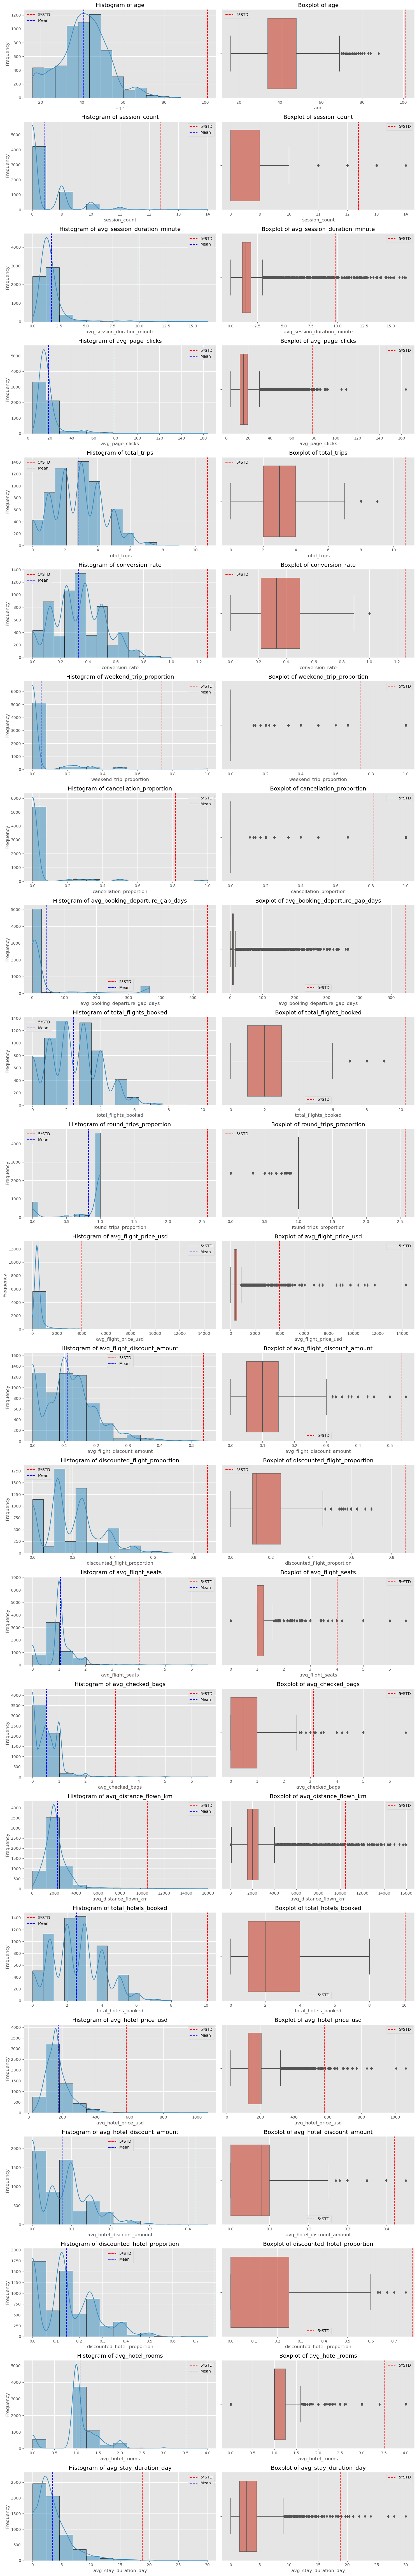

In [14]:
# Select only numerical columns and excluding the user_id column
numerical_columns = [col for col in cohort_users.select_dtypes(include=['float64', 'int64']).columns if col != 'user_id']


# Set up the figure and axes
fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(15, 4 * len(numerical_columns)))

for i, col in enumerate(numerical_columns):
    # Compute the outlier bounds: I commented out the lower_bound as in all the columns it's out of the range
    #lower_bound = cohort_users[col].mean() - 5 * cohort_users[col].std()
    upper_bound = cohort_users[col].mean() + 5 * cohort_users[col].std()
    mean = cohort_users[col].mean()
    
    # Plot histogram
    bins = int(np.log2(len(cohort_users[col])) + 1)  # Sturges' formula
    sns.histplot(cohort_users[col], ax=axes[i, 0], bins=bins, kde=True, edgecolor='black')
    axes[i, 0].set_title(f'Histogram of {col}')
    #axes[i, 0].axvline(lower_bound, color='r', linestyle='--', label=f'-5*STD')
    axes[i, 0].axvline(upper_bound, color='r', linestyle='--', label=f'5*STD')
    axes[i, 0].axvline(mean, color='b', linestyle='--', label='Mean')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].legend()
    
    # Plot box plot
    sns.boxplot(x=cohort_users[col], ax=axes[i, 1], showfliers=True, boxprops=dict(alpha=0.7))
    axes[i, 1].axvline(upper_bound, color='r', linestyle='--', label=f'5*STD')  # Draw the 5*STD line on boxplot
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Few important notes to take:
* These visualizations provided valuable insights into the distribution of the data, helping us make informed decisions for our analysis.
* Using a threshold of __5*STD__ is quite lenient, and values beyond this range are highly likely to be outliers.
* There are multiple columns with data points beyond the 5*STD threshold.
* Some columns, like `avg_session_duration_minute`, have a significant proportion of their data points beyond this threshold.

## <font color=#023e8a>Data Masking for Outlier Removal:</font>

I utilize a masking technique to streamline our outlier filtering process:

* I initiate a universal mask where all data points are considered valid (all set to True).
* For each column, a column-specific mask is created based on outlier detection.
* This column-specific mask is then combined with the universal mask to continuously refine our selection.
* Only data points that remain True across all columns are retained, ensuring a comprehensive filtering of outliers.

This approach ensures robust outlier removal while preserving the integrity of our core data.

In [15]:
# Select only numerical columns and excluding the user_id column
numerical_cols = [col for col in cohort_users.select_dtypes(include=['float64', 'int64']).columns if col != 'user_id']

# Initialize a mask with all True values
mask = pd.Series([True] * len(cohort_users))

for col in numerical_cols:
    mean_value = cohort_users[col].mean()
    std_value = cohort_users[col].std()
    lower_bound = mean_value - 5 * std_value
    upper_bound = mean_value + 5 * std_value
    
    # Update the mask for this column
    column_mask = (cohort_users[col] >= lower_bound) & (cohort_users[col] <= upper_bound)
    mask &= column_mask
    
# Filter the data using the combined mask
cohort_users = cohort_users[mask]

In [16]:
# we had 5998 records
number_of_outliers = 5998 - cohort_users.shape[0]
percentage = round(number_of_outliers/5998 * 100,2)
print(f'{number_of_outliers} ({percentage}%) records were outliers!')

329 (5.49%) records were outliers!


## <font color=#023e8a>Creating new metrics:</font>

We can create one more metric, `average_dollar_saved_per_km` that would be useful for ranking the price-sensitive customers to offer the **Exclusive discounts** perk.

In [17]:
# Caluculating the average_dollar_saved_per_kilometre metric 
avg_usd_saved_per_km = round(cohort_users['avg_flight_discount_amount'] 
                                                    * cohort_users['avg_flight_price_usd'] 
                                                    / cohort_users['avg_distance_flown_km'],2)

# Determine the position to insert the new column after the last_min_booking columns
position = cohort_users.columns.get_loc('avg_distance_flown_km') + 1

# Insert the new column which is the maximum of the both columns at the desired position
cohort_users.insert(position, 'avg_usd_saved_per_km', avg_usd_saved_per_km)

## <font color=#023e8a> Scaling:</font>

Before moving forward, it makes sense to consider rescaling all numerical features to the same range for consistency. This way we ensure that each feature contributes equally to the computation, preventing any one feature from dominating due to its scale. We will use the **StandardScaler** method for rescaling.

However, before applying this transformation, it's crucial to note:
* The transformed values can sometimes be harder to interpret as they no longer represent the original units or scale, this is why we keep the original columns and will add a __"scaled"__ version of each to our dataset.
* The transformed values might have a mean that is not exactly 0 and a standard deviation that is not exactly 1, as StandardScaler scales features based on mean and standard deviation.
* The use of StandardScaler allows us to work with features that are centered around 0, which can be helpful for certain analyses. Since we've already treated outliers, this method should work well in ensuring that our features are properly scaled and ready for segmentation without being overly influenced by outliers.

In [18]:
# List of columns to scale 
cols_to_scale = ['married', 'has_children', 'age', 'session_count', 'avg_session_duration_minute', 'avg_page_clicks', 
                 'total_trips', 'conversion_rate', 'weekend_trip_proportion', 'cancellation_proportion', 
                 'avg_booking_departure_gap_days', 'total_flights_booked', 'round_trips_proportion', 
                 'avg_flight_price_usd', 'avg_flight_discount_amount', 'discounted_flight_proportion', 'avg_flight_seats', 
                 'avg_checked_bags', 'avg_distance_flown_km', 'avg_usd_saved_per_km', 'total_hotels_booked', 
                 'avg_hotel_price_usd', 'avg_hotel_discount_amount', 'discounted_hotel_proportion', 
                 'avg_hotel_rooms', 'avg_stay_duration_day']

# Initialize the StandardScaler
scaler = StandardScaler()
    
# Apply scaling and create new columns with suffix "_scaled"
scaled_data = scaler.fit_transform(cohort_users[cols_to_scale])
scaled_columns = ["scaled_" + col for col in cols_to_scale]
cohort_users[scaled_columns] = scaled_data.round(2)

# check the dataset 
cohort_users.head()

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,session_count,avg_session_duration_minute,avg_page_clicks,total_trips,conversion_rate,weekend_trip_proportion,cancellation_proportion,avg_booking_departure_gap_days,total_flights_booked,round_trips_proportion,avg_flight_price_usd,avg_flight_discount_amount,discounted_flight_proportion,avg_flight_seats,avg_checked_bags,avg_distance_flown_km,avg_usd_saved_per_km,total_hotels_booked,avg_hotel_price_usd,avg_hotel_discount_amount,discounted_hotel_proportion,avg_hotel_rooms,avg_stay_duration_day,has_booked,has_booked_flight,has_booked_hotel,scaled_married,scaled_has_children,scaled_age,scaled_session_count,scaled_avg_session_duration_minute,scaled_avg_page_clicks,scaled_total_trips,scaled_conversion_rate,scaled_weekend_trip_proportion,scaled_cancellation_proportion,scaled_avg_booking_departure_gap_days,scaled_total_flights_booked,scaled_round_trips_proportion,scaled_avg_flight_price_usd,scaled_avg_flight_discount_amount,scaled_discounted_flight_proportion,scaled_avg_flight_seats,scaled_avg_checked_bags,scaled_avg_distance_flown_km,scaled_avg_usd_saved_per_km,scaled_total_hotels_booked,scaled_avg_hotel_price_usd,scaled_avg_hotel_discount_amount,scaled_discounted_hotel_proportion,scaled_avg_hotel_rooms,scaled_avg_stay_duration_day
0,23557,2021-07-22,64,F,True,False,usa,new york,12,6.93,17.50,4,0.33,0.00,0.25,248.05,2,1.0,518.29,0.15,0.21,1.00,1.00,2680.73,0.03,4,157.33,0.18,0.29,1.33,7.33,True,True,True,1.13,-0.69,1.93,4.81,4.98,-0.04,0.73,-0.05,-0.38,2.59,2.07,-0.27,0.5,0.15,0.46,0.21,-0.06,1.10,0.45,0.31,0.95,-0.24,1.52,1.22,0.52,1.44
1,94883,2022-02-07,51,F,True,False,usa,kansas city,12,0.50,8.33,3,0.25,0.00,0.00,60.98,3,1.0,1784.95,0.10,0.08,1.67,1.00,5057.35,0.04,2,90.00,0.08,0.17,1.50,0.50,True,True,True,1.13,-0.69,0.84,4.81,-1.06,-0.92,0.10,-0.48,-0.38,-0.26,0.18,0.36,0.5,3.62,-0.13,-0.75,1.23,1.10,2.51,0.79,-0.37,-1.16,0.06,0.24,0.89,-1.03
3,101961,2022-02-17,42,F,True,False,usa,boston,12,2.00,18.17,7,0.58,0.14,0.00,7.34,6,1.0,321.53,0.13,0.25,1.00,0.50,1753.36,0.02,7,150.29,0.10,0.08,1.00,3.14,True,True,True,1.13,-0.69,0.07,4.81,0.35,0.03,2.61,1.29,0.82,-0.26,-0.36,2.26,0.5,-0.39,0.22,0.51,-0.06,-0.00,-0.35,-0.17,2.94,-0.34,0.35,-0.49,-0.19,-0.08
9,149058,2022-04-14,50,F,False,True,usa,birmingham,12,2.79,15.36,6,0.50,0.00,0.17,58.79,6,1.0,664.40,0.05,0.21,1.56,0.67,2304.81,0.01,6,165.67,0.00,0.14,1.11,8.56,True,True,True,-0.89,1.45,0.75,4.81,1.09,-0.24,1.99,0.86,-0.38,1.68,0.16,2.26,0.5,0.55,-0.72,0.21,1.01,0.37,0.13,-0.65,2.28,-0.13,-1.11,0.00,0.05,1.88
10,152583,2022-04-17,37,F,False,False,usa,colorado springs,10,6.17,21.25,2,0.20,0.00,0.50,181.16,2,1.0,3769.43,0.15,0.25,1.80,1.20,10253.52,0.06,2,213.00,0.15,0.42,1.00,2.00,True,True,True,-0.89,-0.69,-0.35,2.13,4.27,0.33,-0.53,-0.75,-0.38,5.43,1.40,-0.27,0.5,9.06,0.46,0.51,1.47,1.54,6.99,1.76,-0.37,0.52,1.08,2.27,-0.19,-0.49


## <font color=#023e8a> Clustering: Fitting the k-means & choosing best value for k</font>

We aim to prepare our data for clustering analysis. We select specific features and generate a heatmap of their correlation matrix to understand relationships between these features. This step is essential for improving the effectiveness of the clustering algorithm by identifying and potentially addressing issues related to feature correlation.

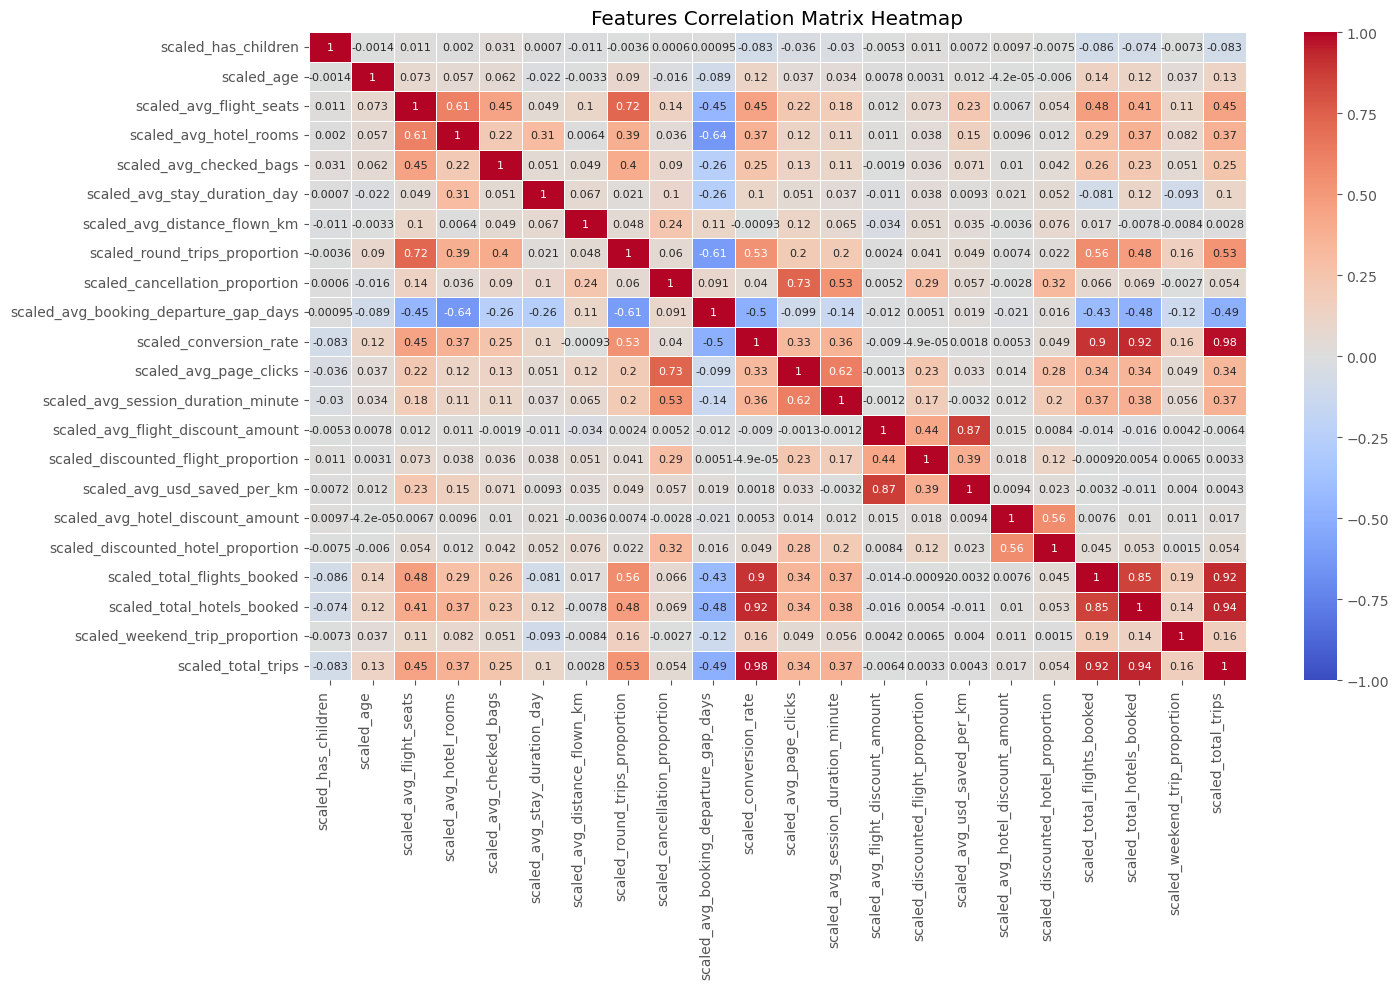

In [20]:
# Extract the relevant columns for clustering
features = cohort_users[[
                  # Free hotel meal:
                  'scaled_has_children',
                  'scaled_age',
                  'scaled_avg_flight_seats', 
                  'scaled_avg_hotel_rooms',
                  # Free checked bag:
                  'scaled_avg_checked_bags',
                  'scaled_avg_stay_duration_day',
                  'scaled_avg_distance_flown_km',
                  'scaled_round_trips_proportion',
                  # No cancellation fees:
                  'scaled_cancellation_proportion',
                  'scaled_avg_booking_departure_gap_days',
                  # Exclusive discounts:
                  'scaled_conversion_rate',
                  'scaled_avg_page_clicks',
                  'scaled_avg_session_duration_minute',
                  'scaled_avg_flight_discount_amount',
                  'scaled_discounted_flight_proportion',
                  'scaled_avg_usd_saved_per_km',
                  'scaled_avg_hotel_discount_amount',
                  'scaled_discounted_hotel_proportion',  
                  # 1-night free hotel with a flight:
                  'scaled_total_flights_booked',
                  'scaled_total_hotels_booked',
                  'scaled_weekend_trip_proportion',
                  'scaled_total_trips'
                        ]]

# Compute the correlation matrix for the free_meal_index
correlation_matrix = features.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5, annot_kws={"size": 8})


# Adjust the x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Set the title and show the plot
plt.title("Features Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

## <font color=#023e8a> Feature Selection Based on Heatmap Insights</font>

Following the heatmap analysis and considering the **iterative process** of feature selection, I have arrived at the following set of features for our clustering analysis:

- `scaled_avg_hotel_rooms`: Reflects the average number of hotel rooms, and will be used for distinguishing users to offer **Free Hotel Meal**. I'll explain later in more detail the logic behind it.
- `scaled_avg_checked_bags`: Reflects the average number of checked bags, and will be used for qualifying travellers for **Free Checked Bag**.
- `scaled_cancellation_proportion`: Proportion of cancellations, will be employed to determine customers to offer **No Cancellation Fees** perk.
- `scaled_conversion_rate`: Conversion rate, will be used to differentiate users to offer the **Exclusive Discounts**.
- `scaled_weekend_trip_proportion`: Proportion of weekend trips, will be used to pick users to propose **1-night free hotel with a flight**.

These features have been carefully chosen as they represent different perks or characteristics of our data that are relevant for clustering. I have commented on other features that were considered but not included in the final selection based on their impact on distinguishing clusters.

These features have been carefully chosen as they represent different perks or characteristics of our data that are relevant for clustering. I have commented out other features that were considered but not included in the final selection based on their impact on distinguishing clusters.

This feature selection process involved extensive **back-and-forth** evaluation to ensure that the chosen features will effectively distinguish our clusters. The selected features are expected to contribute significantly to the clustering analysis, and the code provided displays the first few rows of these selected features for reference.

In [21]:
# Extract the relevant columns for clustering
features = cohort_users[[
                  # Free hotel meal:
                  #'scaled_has_children',
                  #'scaled_age',
                  #'scaled_avg_flight_seats', 
                  'scaled_avg_hotel_rooms',
                  # Free checked bag:
                  'scaled_avg_checked_bags',
                  #'scaled_avg_stay_duration_day',
                  #'scaled_avg_distance_flown_km',
                  #'scaled_round_trips_proportion',
                  # No cancellation fees:
                  'scaled_cancellation_proportion',
                  #'scaled_avg_booking_departure_gap_days',
                  # Exclusive discounts:
                  'scaled_conversion_rate',
                  #'scaled_avg_page_clicks',
                  #'scaled_avg_session_duration_minute',
                  #'scaled_avg_flight_discount_amount',
                  #'scaled_discounted_flight_proportion',
                  #'scaled_avg_usd_saved_per_km',
                  #'scaled_avg_hotel_discount_amount',
                  #'scaled_discounted_hotel_proportion',  
                  # 1-night free hotel with a flight:
                  #'scaled_total_flights_booked',
                  #'scaled_total_hotels_booked',
                  'scaled_weekend_trip_proportion',
                  #'scaled_total_trips'
                        ]]

# Display the first few rows of the selected features
features.head()

,scaled_avg_hotel_rooms,scaled_avg_checked_bags,scaled_cancellation_proportion,scaled_conversion_rate,scaled_weekend_trip_proportion
0,0.52,1.10,2.59,-0.05,-0.38
1,0.89,1.10,-0.26,-0.48,-0.38
3,-0.19,-0.00,-0.26,1.29,0.82
9,0.05,0.37,1.68,0.86,-0.38
10,-0.19,1.54,5.43,-0.75,-0.38


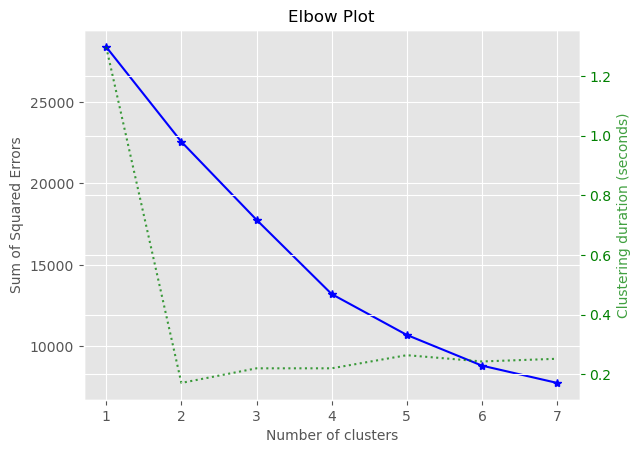

In [22]:
# fitting KMeans and finding appropriate amount of clusters/customer types
model = KMeans(n_clusters=5, random_state=0)
model.fit(features)

plot_elbow_curve(model, features, cluster_ranges=range(1, 8)) # We'll check for up to 7 clusters
plt.show()

Upon analyzing the within-cluster **sum of squared errors (WCSS)** for different cluster numbers, it's observed that the most significant reductions in WCSS occur when increasing the number of clusters from 5 to 6 and from 6 to 7, suggesting that 6 or 7 clusters might be an optimal choice based purely on the elbow method.

However, in the context of TravelTide's objective to categorize customers into five distinct groups to offer five unique perks, there's a clear business motive to proceed with **five clusters**. The difference in WCSS between 4 and 5 clusters, while smaller, is *not negligible*, indicating that a fifth cluster still captures distinct variance in the data.

Given the balance between the data-driven insights from the elbow method and the specific business requirements, it's justified to proceed with five clusters. This approach will not only align with the company's marketing strategy but also ensure that the rewards program is tailored to diverse customer behaviours and preferences, enhancing its potential for success.

We can however also check how good the algorithm is doing in terms of the **silhouette score**:

In [23]:
def get_silhouette_score(features, n_clusters):
    data_sample = features.sample(frac=1, random_state=1)
    model = KMeans(n_clusters=n_clusters, random_state=1)
    model.fit(data_sample)
    
    model_sil_score = silhouette_score(data_sample, model.labels_)
    
    print(f"The silhouette score using {n_clusters} number of clusters is: {round(model_sil_score, 3)}")
    
# calling the function for different number of clusters    
get_silhouette_score(features, 3)
get_silhouette_score(features, 4)
get_silhouette_score(features, 5)
get_silhouette_score(features, 6)
get_silhouette_score(features, 7)

The silhouette score using 3 number of clusters is: 0.314
The silhouette score using 4 number of clusters is: 0.367
The silhouette score using 5 number of clusters is: 0.351
The silhouette score using 6 number of clusters is: 0.378
The silhouette score using 7 number of clusters is: 0.394


#### Observations:
1. The silhouette score is highest for 7 clusters, suggesting that the data might be best segmented into seven distinct groups when considering the similarity of data points within clusters and their dissimilarity with points in other clusters.
2. The score decreases as we move from 4 to 5 clusters and increases for 6 and 7 clusters.

Based on the silhouette scores alone, 7 clusters seem to be the most optimal choice. However, again given our business objective to categorize customers into five distinct groups for the perks, there's a trade-off to consider:
* 7 Clusters: Optimal in terms of data clustering quality (highest silhouette score).
* 5 Clusters: Aligns with the business objective but has a lower silhouette score compared to 7 clusters.

While the silhouette score for 7 clusters might be the highest, it's only slightly higher than the silhouette score for 5 clusters (0.394 vs. 0.351). A silhouette score of 0.351 is still relatively decent and could lead to more meaningful segments for our marketing goals.

## <font color=#023e8a> Labelling the clusters: A look at the cluster centroids</font>

In this section, we're employing the **KMeans clustering algorithm** to segment our customer data into **five distinct clusters**. By examining the centroids of these clusters, we aim to understand the defining characteristics of each group, which will help tailor marketing strategies and offers for each segment effectively.

We're delving deeper into the results of our KMeans clustering by examining the cluster assignments for each data point and visualizing the characteristics of the centroids. Understanding the centroids is crucial because they represent the "average" or "central" behavior of customers in each cluster. The heatmap visualization will offer a clear picture of how each centroid (or cluster center) is positioned in our feature space, aiding in the interpretation of each cluster's significance.

In [24]:
# Retrieving the cluster labels assigned to each data point in our dataset.
cohort_users['cluster_label'] = model.labels_
model.labels_

array([2, 0, 3, ..., 4, 4, 1])

In [25]:
cohort_users.head()

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,session_count,avg_session_duration_minute,avg_page_clicks,total_trips,conversion_rate,weekend_trip_proportion,cancellation_proportion,avg_booking_departure_gap_days,total_flights_booked,round_trips_proportion,avg_flight_price_usd,avg_flight_discount_amount,discounted_flight_proportion,avg_flight_seats,avg_checked_bags,avg_distance_flown_km,avg_usd_saved_per_km,total_hotels_booked,avg_hotel_price_usd,avg_hotel_discount_amount,discounted_hotel_proportion,avg_hotel_rooms,avg_stay_duration_day,has_booked,has_booked_flight,has_booked_hotel,scaled_married,scaled_has_children,scaled_age,scaled_session_count,scaled_avg_session_duration_minute,scaled_avg_page_clicks,scaled_total_trips,scaled_conversion_rate,scaled_weekend_trip_proportion,scaled_cancellation_proportion,scaled_avg_booking_departure_gap_days,scaled_total_flights_booked,scaled_round_trips_proportion,scaled_avg_flight_price_usd,scaled_avg_flight_discount_amount,scaled_discounted_flight_proportion,scaled_avg_flight_seats,scaled_avg_checked_bags,scaled_avg_distance_flown_km,scaled_avg_usd_saved_per_km,scaled_total_hotels_booked,scaled_avg_hotel_price_usd,scaled_avg_hotel_discount_amount,scaled_discounted_hotel_proportion,scaled_avg_hotel_rooms,scaled_avg_stay_duration_day,cluster_label
0,23557,2021-07-22,64,F,True,False,usa,new york,12,6.93,17.50,4,0.33,0.00,0.25,248.05,2,1.0,518.29,0.15,0.21,1.00,1.00,2680.73,0.03,4,157.33,0.18,0.29,1.33,7.33,True,True,True,1.13,-0.69,1.93,4.81,4.98,-0.04,0.73,-0.05,-0.38,2.59,2.07,-0.27,0.5,0.15,0.46,0.21,-0.06,1.10,0.45,0.31,0.95,-0.24,1.52,1.22,0.52,1.44,2
1,94883,2022-02-07,51,F,True,False,usa,kansas city,12,0.50,8.33,3,0.25,0.00,0.00,60.98,3,1.0,1784.95,0.10,0.08,1.67,1.00,5057.35,0.04,2,90.00,0.08,0.17,1.50,0.50,True,True,True,1.13,-0.69,0.84,4.81,-1.06,-0.92,0.10,-0.48,-0.38,-0.26,0.18,0.36,0.5,3.62,-0.13,-0.75,1.23,1.10,2.51,0.79,-0.37,-1.16,0.06,0.24,0.89,-1.03,0
3,101961,2022-02-17,42,F,True,False,usa,boston,12,2.00,18.17,7,0.58,0.14,0.00,7.34,6,1.0,321.53,0.13,0.25,1.00,0.50,1753.36,0.02,7,150.29,0.10,0.08,1.00,3.14,True,True,True,1.13,-0.69,0.07,4.81,0.35,0.03,2.61,1.29,0.82,-0.26,-0.36,2.26,0.5,-0.39,0.22,0.51,-0.06,-0.00,-0.35,-0.17,2.94,-0.34,0.35,-0.49,-0.19,-0.08,3
9,149058,2022-04-14,50,F,False,True,usa,birmingham,12,2.79,15.36,6,0.50,0.00,0.17,58.79,6,1.0,664.40,0.05,0.21,1.56,0.67,2304.81,0.01,6,165.67,0.00,0.14,1.11,8.56,True,True,True,-0.89,1.45,0.75,4.81,1.09,-0.24,1.99,0.86,-0.38,1.68,0.16,2.26,0.5,0.55,-0.72,0.21,1.01,0.37,0.13,-0.65,2.28,-0.13,-1.11,0.00,0.05,1.88,2
10,152583,2022-04-17,37,F,False,False,usa,colorado springs,10,6.17,21.25,2,0.20,0.00,0.50,181.16,2,1.0,3769.43,0.15,0.25,1.80,1.20,10253.52,0.06,2,213.00,0.15,0.42,1.00,2.00,True,True,True,-0.89,-0.69,-0.35,2.13,4.27,0.33,-0.53,-0.75,-0.38,5.43,1.40,-0.27,0.5,9.06,0.46,0.51,1.47,1.54,6.99,1.76,-0.37,0.52,1.08,2.27,-0.19,-0.49,2


,scaled_avg_hotel_rooms,scaled_avg_checked_bags,scaled_cancellation_proportion,scaled_conversion_rate,scaled_weekend_trip_proportion
0,0.203140,0.718430,-0.252331,0.398117,-0.373519
1,-2.340000,-0.966199,-0.260000,-1.723496,-0.380000
2,0.171943,0.342979,3.462332,0.321010,0.004534
3,0.215061,0.108494,-0.238060,0.628589,2.301248
4,0.258524,-0.790872,-0.260000,-0.372912,-0.380000


Text(0.5, 1.0, 'Centroid positions in high-dimensional space')

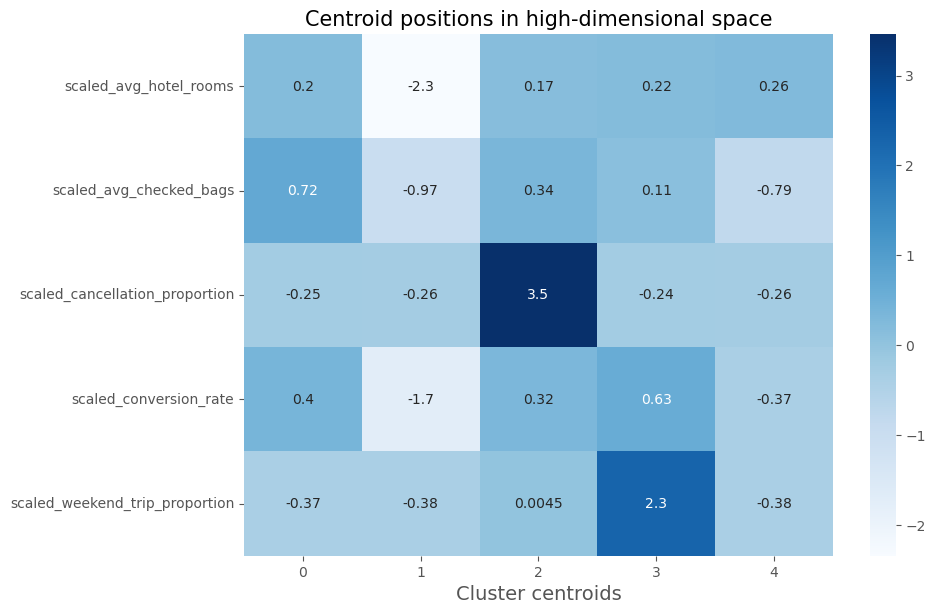

In [27]:
# Constructing a DataFrame to represent the cluster centroids with respective feature values.
model_centroids = pd.DataFrame(model.cluster_centers_, columns=features.columns)

# Displaying the coordinates/values of each cluster centroid in a tabular format.
display(model_centroids)

# Plotting a heatmap to visually represent the position and magnitude of each cluster centroid in the feature space.
plt.figure(figsize=(10, 6))
sns.heatmap(model_centroids.T, cmap="Blues", annot=True)
plt.xlabel("Cluster centroids", fontsize=14)
plt.tight_layout()
plt.title("Centroid positions in high-dimensional space", fontsize=15)

Through analyzing the heatmap, we can identify distinct patterns and trends that differentiate one cluster from another. Clusters that exhibit higher values in specific features will be represented by darker shades on the heatmap. This visual aid can assist in making informed decisions about how to allocate perks to various customer segments, ensuring that they align with observed behaviors and preferences. Let's examine the perks we have available for segmenting our customers and determine which cluster each belongs to.

### <font color=#0077b6>1. Free hotel meal:</font> 

**Families** and **large tour groups** might prefer the convenience of a hotel meal to simplify logistics and keep meals consistent.

**Relevant Feature:** `scaled_avg_hotel_rooms`

**Best Fit:** **Cluster 4**, as it has highest value in the relevant feature.

### <font color=#0077b6>2. Free checked bags:</font> 
Those passengers who already have a high number of average checked bags, will appreciate this perk.

**Relevant Feature:** `scaled_avg_checked_bags`

**Best Fit:** **Cluster 0**, shows highest value in the relevant feature.

### <font color=#0077b6>3. No cancellation fees:</font> 

**Travelers with a High Number of Cancelled Trips** are likely value flexibility in future bookings to avoid incurring costs.

**Relevant Feature:** `cancellations_proportion`

**Best Fit:** **Cluster 2**, as it has the highest cancellation proportion.

### <font color=#0077b6>4. Exclusive discounts:</font> 

This one is a bit unclear compared to the other perks. Based on what the Marketing Manager said, we're looking for **price-sensitive customers.**

**Relevant Feature:** `conversion_rate`: A low conversion rate, indicating unwillingness to buy except at a low enough price

**Best Fit:** **Cluster 1**, as it has the lowest conversion rate.

### <font color=#0077b6>5. 1-night free hotel with a flight:</font> 
**Short-Stay Travelers** or **Weekend Getaway Travelers** who typically book short stays might find this perk particularly enticing as it significantly reduces their accommodation cost.

**Relevant Feature:** `weekend_trip_proportion`

**Best Fit:** **Cluster 3**, as it has the highest value the relevant feature.

So I'll assign each cluster to the perks:

In [28]:
cluster_dict = {0:'Free Checked Bag',
               1: 'Exclusive Discounts',
               2: 'No Cancellation Fee',
               3: '1-night free hotel with a flight',
               4: 'Free Hotel Meal'} 

# Add a new column to the DataFrame to store the perk names
cohort_users['perk'] = cohort_users['cluster_label'].map(cluster_dict)

# Count the number of users in each segment
segment_counts = cohort_users['perk'].value_counts().reset_index()
segment_counts.columns = ['perk', 'user_count']

# Display the number of users in each segment
segment_counts

,perk,user_count
0,Free Checked Bag,2299
1,Free Hotel Meal,1755
2,1-night free hotel with a flight,737
3,Exclusive Discounts,492
4,No Cancellation Fee,386


In [29]:
grouped_df = features.join(cohort_users['perk']).groupby('perk').mean()
grouped_df

,scaled_avg_hotel_rooms,scaled_avg_checked_bags,scaled_cancellation_proportion,scaled_conversion_rate,scaled_weekend_trip_proportion
perk,,,,,
1-night free hotel with a flight,0.215061,0.108494,-0.238060,0.628589,2.301248
Exclusive Discounts,-2.340000,-0.966199,-0.260000,-1.723496,-0.380000
Free Checked Bag,0.203140,0.718430,-0.252331,0.398117,-0.373519
Free Hotel Meal,0.258524,-0.790872,-0.260000,-0.372912,-0.380000
No Cancellation Fee,0.171943,0.342979,3.462332,0.321010,0.004534


We can check the average amount for each feature in all the perks. Our initial analysis can be confirmed, when we look at the actual underlying datapoints. 
To get a better understanding of each of the clusters, we can plot their distribution in regards to each of the chosen variables to make sure our cluster averages are not defined by large outliers (this is a check to make sure our k-means clusters are robust).

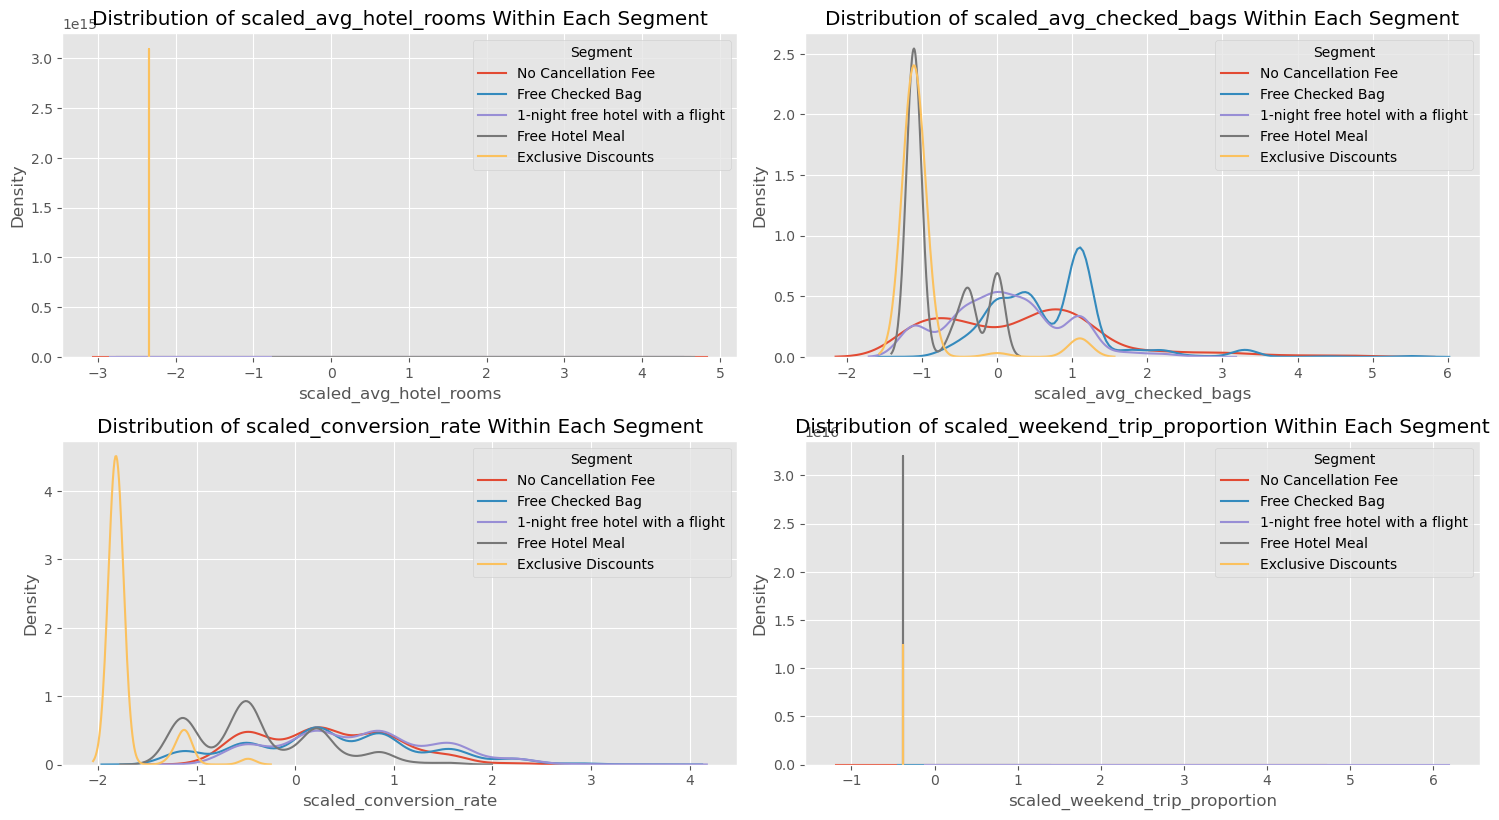

In [32]:
"""
'scaled_cancellation_proportion' is being excluded because it has limited variation or unique values, which can lead 
to issues when generating kernel density estimates (KDE) for visualization.
The KDE estimation works better when there is a range of values to model, and removing it helps avoid 
problems like singular matrices in the KDE estimation process.
"""
filtered_columns = [col for col in grouped_df.columns if col != 'scaled_cancellation_proportion'] 

# Extract unique segment labels from the 'perk' column
segments = cohort_users['perk'].unique()

# Calculate the number of rows and columns for the subplot grid
n_rows = len(filtered_columns)  # One row per feature
n_cols = 2  # Two columns per row

# Create subplots with explicit layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * len(filtered_columns)))


# Loop through each feature and create KDE plots for each segment
for i, feature in enumerate(filtered_columns):
    row, col = divmod(i, n_cols)  # Calculate row and column for current subplot
    for segment in segments:
        sns.kdeplot(
            cohort_users[cohort_users['perk'] == segment][feature],
            label=segment,
            ax=axes[row, col]
        )
    
    axes[row, col].set_title(f'Distribution of {feature} Within Each Segment')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Density')
    axes[row, col].legend(title='Segment')


# Hide any remaining empty subplots
for i in range(len(filtered_columns), n_rows * n_cols):
    row, col = divmod(i, n_cols)  # Calculate row and column for current subplot
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

The **Kernel Density Estimation (KDE) plot** above illustrates the distribution of all features across all clusters. These are some general Observations:

* **Overlap of Distributions:** In some cases, we see a significant overlap in the distributions of different segments, suggesting that there is a similarity in the behavior of different customer groups for these features.

* **Outliers:** In some distributions, there are tails extending towards the higher end, indicating the presence of outliers or customers with extreme values for these features.

* **Unique Behaviors:** Each segment exhibits unique behaviors for certain features, such as the "Free Checked Bag" segment showing a higher average number of checked bags, and the "Exclusive Discounts" segment showing lower conversion rates.

### Exploring the Overlap in Perk Preferences:

**Distribution of Feature Values Across All Perks**

Due to the nature of KDE plots, we can't see all the insights, so plotting a boxplot can provide a comprehensive view of how the feature values are distributed across the five different perks. 

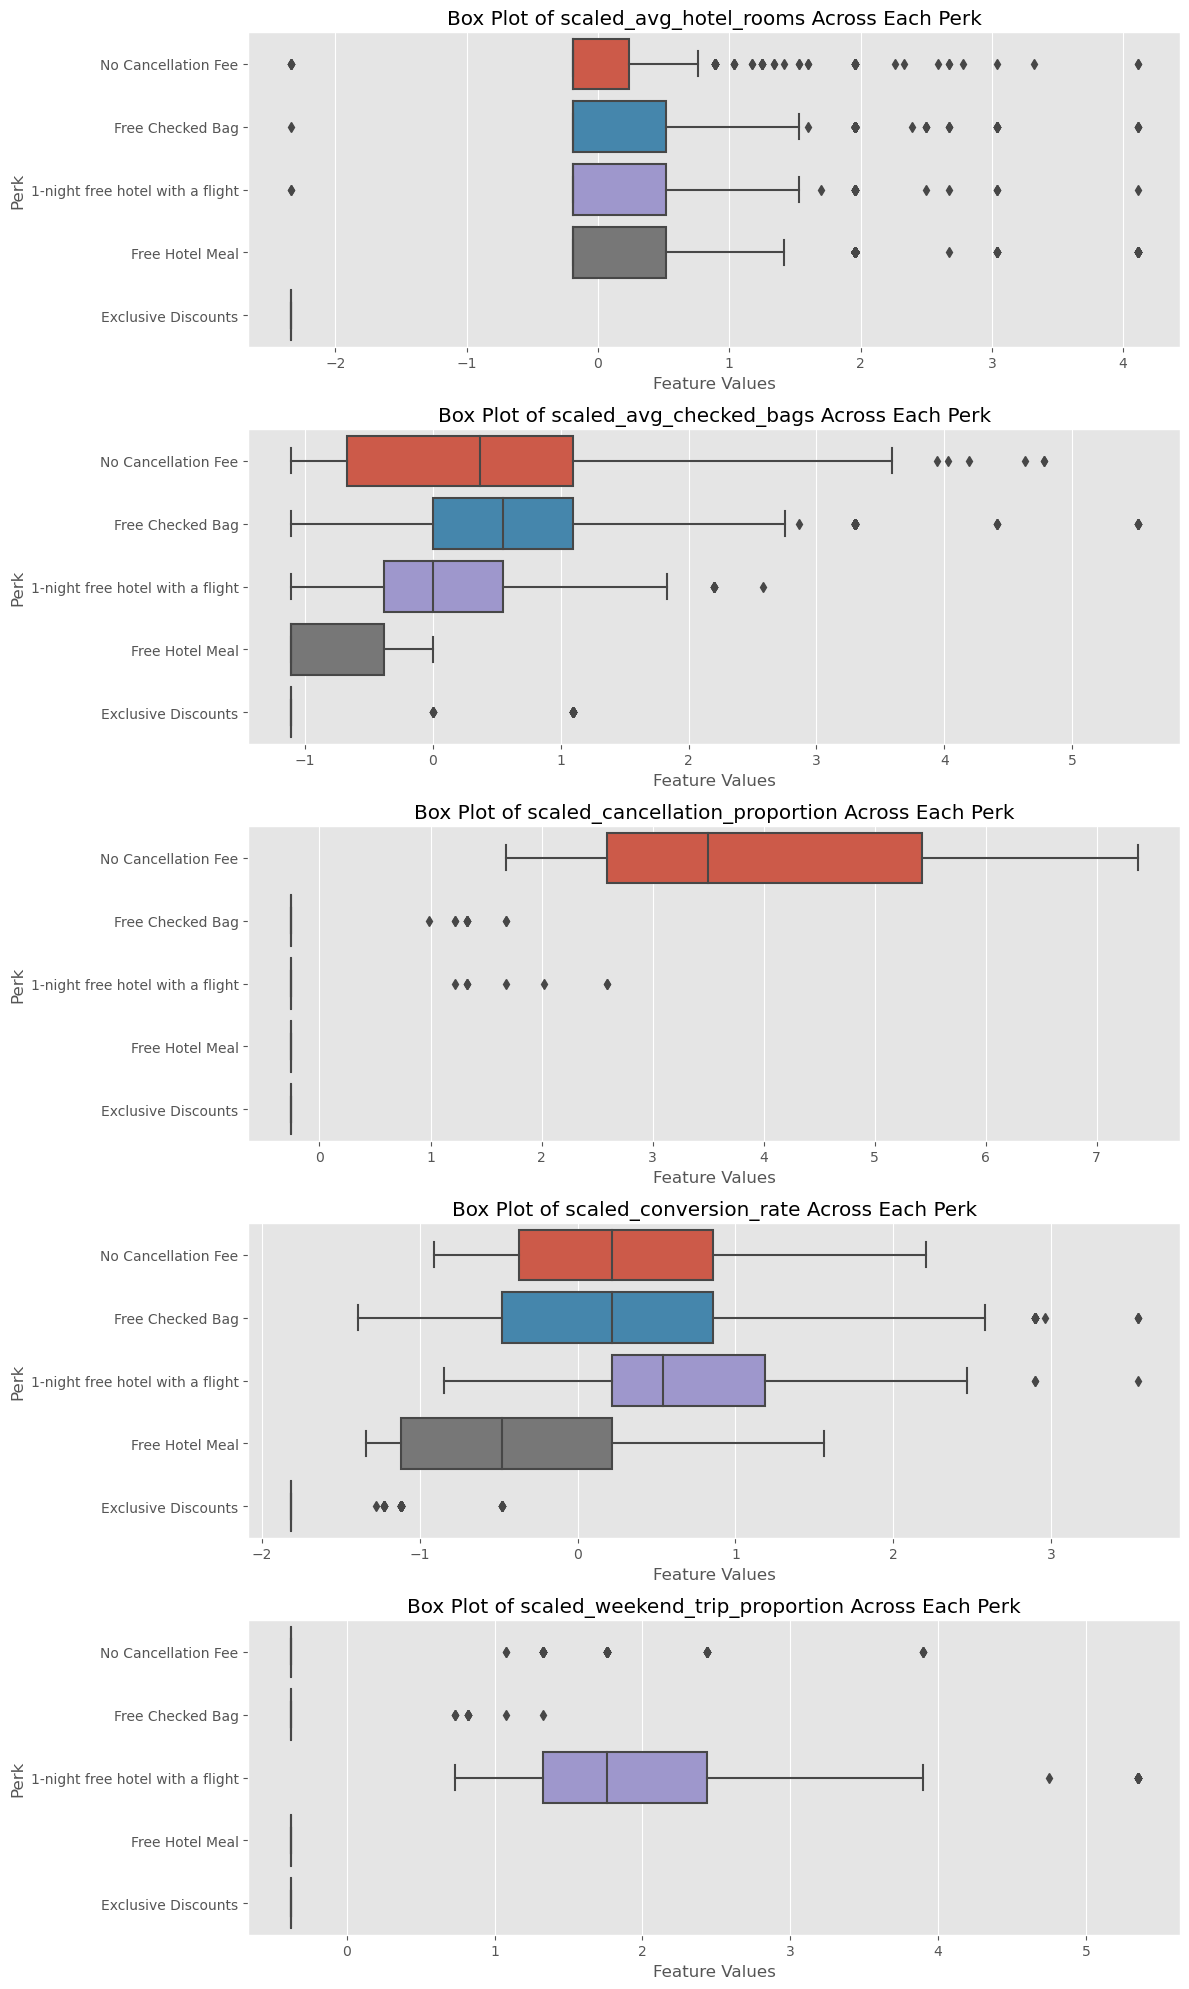

In [59]:
# Calculate the number of rows for the subplot grid (one row per feature)
n_rows = len(features.columns)

# Create subplots with explicit layout, one subplot per row
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 4 * len(features.columns)))

# Loop through each feature to create box plots for each segment
for i, feature in enumerate(features.columns):
    sns.boxplot(y='perk', x=feature, data=cohort_users, ax=axes[i])
    
    axes[i].set_title(f'Box Plot of {feature} Across Each Perk')
    axes[i].set_xlabel('Feature Values')
    axes[i].set_ylabel('Perk')

plt.tight_layout()
plt.show()

Upon reviewing the distribution of each feature across the different perks, and checking the associated feature for each perk, we can observe that some of the clusters/segments are well-defined. Specifically, the perks that stand out are **No Cancellation Fees**, **1-night Free Hotel with a Flight**, and **Exclusive Discounts**. The **Free Checked Bag** is performing moderately well, however, the **Free Hotel Meal** feature has a significant overlap with Free Checked Bag and 1 night Free Hotel with a Flight.

**Key Takeaway:**

Overlaps could be an opportunity for bundling perks or creating tiered reward programs. By understanding this overlap, we can more effectively tailor our rewards program to meet diverse customer needs, potentially increasing customer satisfaction and loyalty.

## <font color=#023e8a> Within cluster inertia:</font>

**Cluster Density:** 

The **average distance to the centroid** for each cluster gives an idea of how **"tight"** each cluster is. **Lower average distances** mean **more dense clusters**, and **higher distances** could indicate **more outliers**.

In [33]:
from sklearn.metrics.pairwise import euclidean_distances

# Make a copy of the DataFrame slice
features_copy = features.copy()

# Add the cluster labels to the DataFrame containing the features
features_copy['cluster_label'] = cohort_users['cluster_label']
features_copy['perk'] = cohort_users['perk']

# Initialize an empty column to store the distances to the cluster centroid
features_copy['dist_center'] = None

# Loop through each cluster to calculate the distance of each point to its cluster's centroid
for cluster in model_centroids.index:
    cluster_sample = features_copy.loc[features_copy['cluster_label'] == cluster]
    
    features_copy.loc[features_copy['cluster_label'] == cluster, 'dist_center'] = euclidean_distances(
        cluster_sample.iloc[:, :-3],  # Exclude the last three columns: 'cluster_label', 'perk', 'dist_center'
        model_centroids.loc[cluster, :].values.reshape(1, -1)
    )
    
# Calculate the average distance of the data points in each cluster to their respective centroid
avg_dist_to_centroid = features_copy.groupby('perk', as_index=False)['dist_center'].mean()
avg_dist_to_centroid

,perk,dist_center
0,1-night free hotel with a flight,1.500694
1,Exclusive Discounts,0.331363
2,Free Checked Bag,1.209937
3,Free Hotel Meal,1.024512
4,No Cancellation Fee,2.027350


The cluster **"Exclusive Discounts"** has the lowest average distance to the centroid, making it the most "dense." This might suggest that **users in this cluster have very similar behaviors or characteristics**. 

**Representative Samples:**
The concept here is to take samples that are very close to the centroid (hence, "representative" of the cluster) and study them in more detail. We could study these customers more closely to understand their needs, reactions to new features, etc.
Let's look at the distance distribution within each cluster and take the samples from the closest quartile to the centroid.

In [34]:
# Define the function to draw representative examples from each cluster (perk category in this case)
def draw_examples(df, perk, max_dist, n):
    print(f"Examples from cluster {perk} with less than {max_dist} distance to the cluster centroid")
    return df.loc[(df['perk'] == perk) & (df['dist_center'] < max_dist)].sample(n)

# Draw 5 representative examples from the 'No Cancellation Fee' cluster
# Replace 0.4 with the appropriate maximum distance based on your specific dataset
draw_examples(features_copy, perk='Exclusive Discounts', max_dist=0.4, n=5)

Examples from cluster Exclusive Discounts with less than 0.4 distance to the cluster centroid


,scaled_avg_hotel_rooms,scaled_avg_checked_bags,scaled_cancellation_proportion,scaled_conversion_rate,scaled_weekend_trip_proportion,cluster_label,perk,dist_center
3122,-2.34,-1.11,-0.26,-1.82,-0.38,1,Exclusive Discounts,0.173181
1670,-2.34,-1.11,-0.26,-1.82,-0.38,1,Exclusive Discounts,0.173181
4646,-2.34,-1.11,-0.26,-1.82,-0.38,1,Exclusive Discounts,0.173181
688,-2.34,-1.11,-0.26,-1.82,-0.38,1,Exclusive Discounts,0.173181
2480,-2.34,-1.11,-0.26,-1.82,-0.38,1,Exclusive Discounts,0.173181


We can also take a look at the average amount of features in each perk.

In [35]:
# Calculate various metrics for each cluster (perk)
cluster_metrics = features_copy.groupby('perk', as_index=False).agg({
    'scaled_conversion_rate': 'mean',
    'scaled_avg_hotel_rooms': 'mean',
    'scaled_avg_checked_bags': 'mean',
    'scaled_cancellation_proportion': 'mean',
    'scaled_weekend_trip_proportion': 'mean'
})

# Rename columns for clarity
cluster_metrics.columns = ['Perk', 'Avg Conversion Rate', 'Avg Hotel Rooms', 'Avg Checked Bags', 
                           'Avg Cancellation Proportion', 'Avg Weekend Trip Proportion']

# Display the calculated metrics as a table
cluster_metrics

,Perk,Avg Conversion Rate,Avg Hotel Rooms,Avg Checked Bags,Avg Cancellation Proportion,Avg Weekend Trip Proportion
0,1-night free hotel with a flight,0.628589,0.215061,0.108494,-0.238060,2.301248
1,Exclusive Discounts,-1.723496,-2.340000,-0.966199,-0.260000,-0.380000
2,Free Checked Bag,0.398117,0.203140,0.718430,-0.252331,-0.373519
3,Free Hotel Meal,-0.372912,0.258524,-0.790872,-0.260000,-0.380000
4,No Cancellation Fee,0.321010,0.171943,0.342979,3.462332,0.004534


* Among the identified clusters, the **Exclusive Discounts** cluster exhibits the lowest average conversion rate. This finding aligns strategically with the business objective of targeting segments with lower conversion rates. Implementing tailored strategies, such as offering exclusive discounts, to engage and enhance the conversion rate within this group could yield significant results.

* Notably, the feature **Average Hotel Rooms** boasts the highest values within the **Free Hotel Meal** cluster, closely followed by the **1-night Free Hotel** and **Free Checked Bag** clusters.

* The cluster associated with the **Free Checked Bag** perk exhibits the highest average checked bag count, fulfilling the intended goal effectively.

* Impressively, the **No Cancellation Proportion** cluster emerges with the highest average cancellation proportion by a considerable margin. This observation reflects the alignment of this perk with a distinct customer preference for flexibility.

* The **1-night Free Hotel with a Flight** perk cluster stands out with the highest average weekend trip proportion. This finding underscores the appeal of weekend trips within this particular customer segment.

These observations provide valuable insights for tailoring marketing strategies and perk offerings to specific customer clusters, ultimately enhancing customer engagement and satisfaction.

## <font color=#023e8a>Exploratory Data Analysis for Segmentation</font> 

Before moving on to the final step and export the customer segmentation csv file, it's crucial to perform some EDA to better understand the segmentation. This will help in validating the data and ensuring that the segments align with the proposed perks. It will also serve as a basis for providing evidence-based insights.

### <font color=#0077b6>Distribution of Customers Across Different Segments:</font> 
First, let's plot a bar chart to visualize how many customers belong to each segment. This will give us an overall idea of the segmentation distribution.

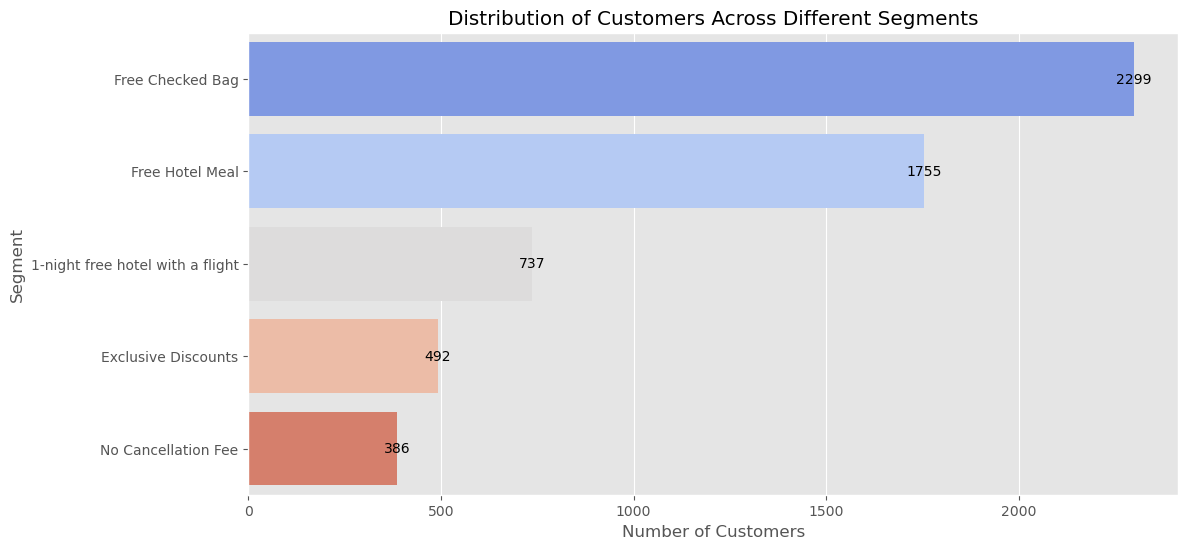

In [36]:
# Count the number of customers in each segment
segment_count = cohort_users['perk'].value_counts().reset_index()
segment_count.columns = ['Segment', 'Number of Customers']

# Plotting the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Number of Customers', y='Segment', data=segment_count, palette='coolwarm')
plt.title('Distribution of Customers Across Different Segments')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')

# Annotate bars with count values
for index, value in enumerate(segment_count['Number of Customers']):
    plt.text(value, index, str(value), ha='center', va='center', fontsize=10, color='black')

#plt.tight_layout()
plt.show()

The bar chart above shows the distribution of customers across different segments based on the perks they are most likely to value. The segments are:

* **Free Checked Bag:** This segment has the highest number of customers, suggesting that a significant portion of our customer base consider baggage costs when booking flights and would value a perk that offers free checked bags.

* **Free Hotel Meal:** Following the first segment, suggesting a considerable number of customers value a free hotel meal as an attractive perk.

* **1-night Free Hotel with a Flight:** This is the third-largest segment, suggesting suggesting a significant number of frequent flyers who would appreciate a free hotel stay.

* **Exclusive Discounts:** This segment shows that a considerable number of customers are price-sensitive and would appreciate exclusive discounts.

* **No Cancellation Fee:** The smallest segment, suggesting that flexibility in cancellation is valued by a small portion of the customer base.

This distribution aligns well with the Marketing team's proposed perks, suggesting that each proposed perk targets a significant customer segment.

I'll also plot the donut chart to use it later in my presentation:

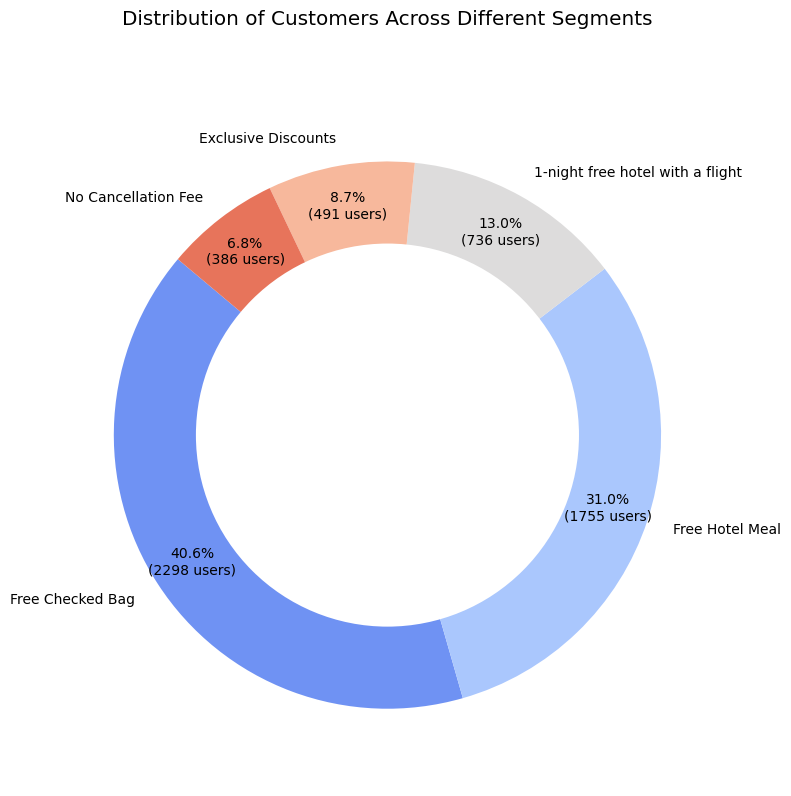

In [37]:
# to use it in the presentation file:

def func(pct, allvalues): 
    absolute = int(pct/100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} users)".format(pct, absolute)

# Data to plot
sizes = segment_count['Number of Customers']
labels = segment_count['Segment']
colors = sns.color_palette('coolwarm', len(labels))

# Plotting the Pie chart
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: func(pct, sizes), startangle=140, pctdistance=0.85)

# Drawing center circle for 'Donut' style
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Use the y parameter to adjust the position of the title
plt.title('Distribution of Customers Across Different Segments', y=1.08)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

### <font color=#0077b6>Average Age Across Segments:</font> 

Next, let's plot the average age of customers in each segment to see if certain perks are more appealing to different age groups.

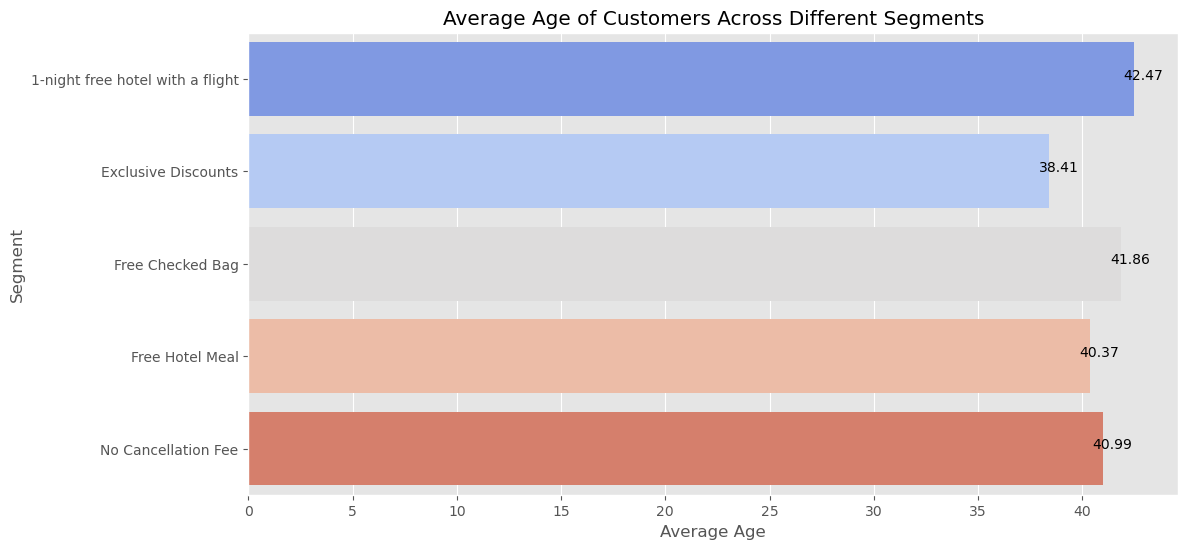

In [39]:
# Calculate the average age for each segment
avg_age_segment = cohort_users.groupby('perk')['age'].mean().reset_index()
avg_age_segment.columns = ['Segment', 'Average Age']

# Plotting the bar chart for average age
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Average Age', y='Segment', data=avg_age_segment, palette='coolwarm')

# Annotate the average age of each segment
for index, value in enumerate(avg_age_segment['Average Age']):
    ax.text(value - 0.5, index, str(round(value, 2)))

plt.title('Average Age of Customers Across Different Segments')
plt.xlabel('Average Age')
plt.ylabel('Segment')
plt.show()

The bar chart displays the average age of customers across different segments. As we can see the average age in all segments are very close to each other. 

* **1-night Free Hotel with a Flight:** This segment has the highest average age, suggesting that older customers may find a one night free hotel more appealing.

* **Exclusive Discounts:** This segment has the lowest average ages, suggesting that younger, might value are more budget travellers.

This information could be valuable for targeted marketing and customization of perk offers.

### <font color=#0077b6>Gender Distribution Across Segments:</font> 

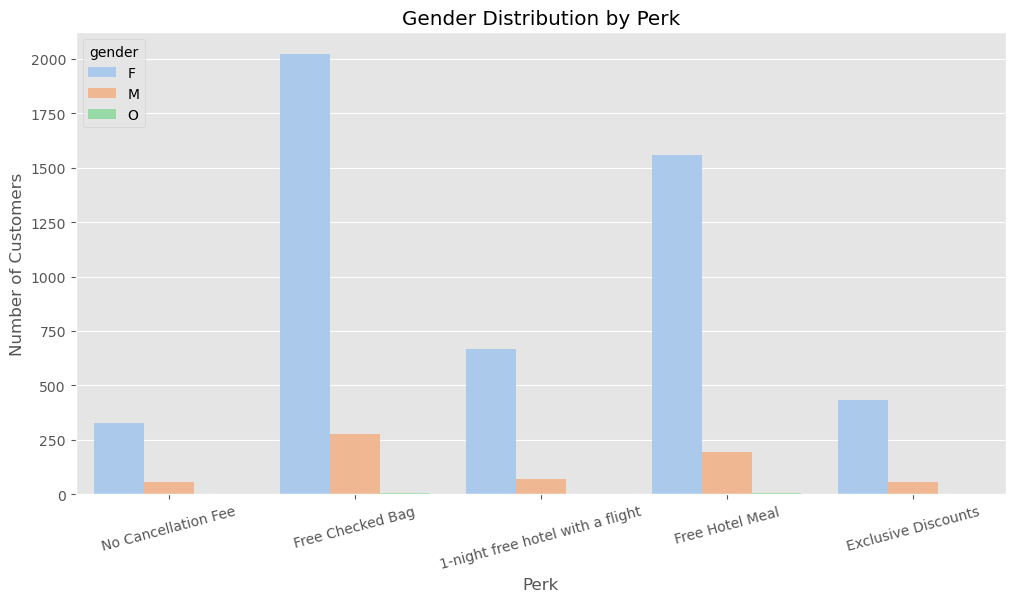

In [40]:
# Gender analysis: drawing the countplot for gender distribution across different perks using
plt.figure(figsize=(12, 6))
sns.countplot(data=cohort_users, x='perk', hue='gender', palette="pastel")
plt.title('Gender Distribution by Perk')
plt.xlabel('Perk')
plt.ylabel('Number of Customers')
plt.xticks(rotation=15)
plt.show()

The gender distribution across the five perks shows a consistent trend: **the number of females is higher across all perks**. This suggests that the proposed perks are more frequently aligned with female customers in our dataset.

This gender disparity may reflect the broader user base and could be significant for tailoring marketing messages or further refining the perks to appeal to a more balanced audience.

### <font color=#0077b6>Geographical Analysis:</font> 

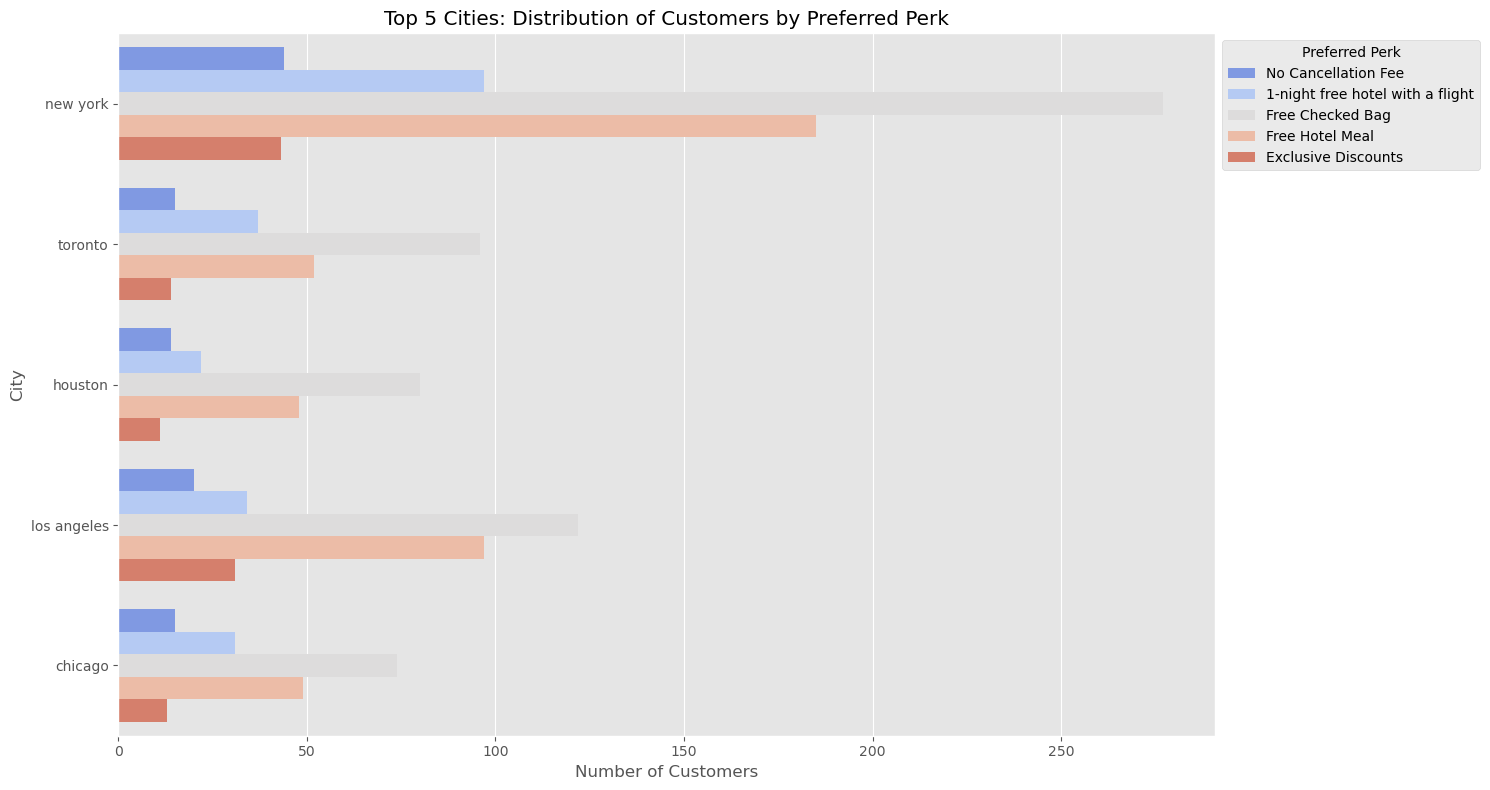

In [48]:
# Plotting the distribution of customers across top 5 cities and their most preferred perk
top_5_cities = cohort_users['home_city'].value_counts().nlargest(5).index.tolist()

# Filter the data to only include the top 5 cities
top_5_cities_data = cohort_users[cohort_users['home_city'].isin(top_5_cities)]

# Generate a horizontal bar chart for the top 5 cities
plt.figure(figsize=(15, 8))
sns.countplot(data=top_5_cities_data, y='home_city', hue='perk', palette="coolwarm")
plt.title('Top 5 Cities: Distribution of Customers by Preferred Perk')
plt.xlabel('Number of Customers')
plt.ylabel('City')
plt.legend(title='Preferred Perk', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

The horizontal bar chart illustrates the distribution of customers based on their preferred perks within the top 5 cities.

**New York City:** The chart shows that "Free Checked Bag" is the most popular perk among customers, followed by "Free Hotel Meal" and "1-night Free Hotel with a Flight."

For the other cities, **Toronto**, **Houston**, **Los Angeles** and **Chicago**, the pattern is the same as New York City, at least fot the top three perks.

## <font color=#023e8a>Customer Segmentation Analysis and Next Steps</font> 

### Key Insights:

#### 1. Cluster Sizes and Demographics:

* The majority of customers value the "Free Checked Bag" perk, indicating that many consider baggage costs when making travel decisions.
* The average age across the perks suggests that older customers tend to value "1-night Free Hotel with a Flight" while younger customers are more price-sensitive, preferring the "Exclusive Discounts" perk.
* The gender distribution points to a higher alignment of the perks with female customers. This could be a reflection of the broader user base or an area for further investigation.
* Geographically, the preferences for perks are consistent across major cities, with "Free Checked Bag", "Free Hotel Meal", and "1-night Free Hotel with a Flight" being the top three in most cities.

#### 2. Perk Preferences and Behaviors:

* The "No Cancellation Fee" perk appeals to a niche segment of customers, indicating that while it's a smaller group, they have a distinct preference for flexibility.
* The "Exclusive Discounts" segment has the lowest conversion rate, suggesting that they need additional incentives to complete a purchase. This makes the perk well-aligned with their behavior.
* The "1-night Free Hotel with a Flight" perk is attractive to those who often take weekend trips, which could be indicative of frequent business travelers or short getaway enthusiasts.

#### 3. Overlap in Perk Preferences:

* Some overlap exists in the distribution of features across different perks. For instance, the "Free Hotel Meal" perk shows significant overlap with "Free Checked Bag" and "1-night Free Hotel with a Flight". This could indicate shared preferences or behaviors among these groups.

#### 4. Opportunity for More Customized Offerings
* The segmentation suggests that we have an opportunity to offer more nuanced perks based on the secondary preferences of our customers, allowing us to create a more compelling rewards program over time.

### Recommendations:

#### 1. Refinement of Perk Offerings:

* Given the overlap between certain perks, consider bundling perks or offering tiered rewards. For instance, a combined perk of "Free Checked Bag + 1-night Free Hotel with a Flight" could be tested for its appeal.
* For the "No Cancellation Fee" segment, consider additional perks or incentives that cater to their need for flexibility, such as "Flexible Dates" or "Priority Rescheduling".

#### 2. Tailored Marketing Campaigns:

* Design marketing campaigns that cater to the specific behaviors and preferences of each segment. For instance, target the "Exclusive Discounts" segment with special limited-time offers to boost their conversion rate.
* For the gender disparity observed, consider gender-specific campaigns or investigate the reasons for the disparity to ensure a balanced appeal.

#### 3. Performance Monitoring:
* Keep an eye on KPIs such as engagement rate, conversion rate, and customer lifetime value to measure the success of these personalized campaigns.

#### 4. Engagement with High-Value Segments:

* Recognize and engage with segments that exhibit high-value behaviors, such as booking for larger groups (reflected in higher "avg_hotel_rooms") or frequent flying. Personalized loyalty programs or premium services could be offered to these customers.

#### 5. Strategic Expansion:

* Given the consistent perk preferences across major cities, consider a uniform rewards program rollout in these cities. However, monitor regional preferences and be ready to adjust based on feedback.

### Conclusion:

The segmentation analysis offers invaluable insights into the diverse preferences and behaviors of TravelTide's customer base. By aligning perks with these insights and continuously refining the offerings, TravelTide can enhance customer satisfaction, boost loyalty, and drive growth.

With these insights, we are now ready to finalize our segmented list of customers, each assigned to the perk they are most likely to appreciate. This data will serve as the foundation for the pilot phase of our rewards program. We'll now proceed to export the segmented data to a CSV file, which will include each customer's user_id and their respective segment label. This will be invaluable for downstream marketing activities.

In [49]:
final_segmentation_df = cohort_users[['user_id','perk']]

# Save the DataFrame to a CSV file
final_segmentation_df.to_csv('TravelTide_Customer_Segmentation_Kmean.csv', index=False)

# Display the first few rows of the final DataFrame
final_segmentation_df.head()

,user_id,perk
0,23557,No Cancellation Fee
1,94883,Free Checked Bag
3,101961,1-night free hotel with a flight
9,149058,No Cancellation Fee
10,152583,No Cancellation Fee
